# E-mail classification
Service departments are often providing a central e-mailadres to their (internal or external) customers for reporting issues. Often, different topics are handled by different people or departments. Wouldn’t it be great to have an automatic e-mail classifier that forwards e-mails to the right person? Let’s try to make this.  
  
We start from a set of 9.820 real e-mails originating from several e-mail services like monster.com, nieuwsblad.be, datanews.be, etc.. The e-mails belong to four categories: _advertisements_ , _job offerings_ , _news_ and _ICT_ . We’d like to create a classifier that can be used to automatically classify e-mails into one of the four categories ADS, JOB, NEWS and ICT. 
We start by importing and exploring the data. 


In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

import seaborn as sns                               # Advanced data visualisation

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model


import nltk


2.8.0


In [2]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
else:
    colab = False
    print ('You are not running on Google Colab')

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

You are not running on Google Colab


Read the files

In [14]:
import numpy as np
import pandas as pd

ads = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailADS.csv',encoding = "ISO-8859-1")
ict = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailICT.csv',encoding = "ISO-8859-1")
job = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailJOB.csv',encoding = "ISO-8859-1")
news = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailNEWS.csv',encoding = "ISO-8859-1")


Merge the 4 panda dataframes into 1 dataframe called data


In [15]:
data = ads.append([ict,job,news])

C:\Users\jcor864\AppData\Local\Temp\ipykernel_25940\3339414562.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ads.append([ict,job,news])


Combine the columns Subject and Body into 1 column Text  
Keep only the columns Category and Text

In [16]:
data = data[['Subject','Body','Category']]  # we only keep these three columns 
data['Text'] = data['Subject'] + ' ' + data['Body']
data = data.drop(['Subject','Body'],axis=1)
data.head()

,Category,Text
0,ADS,Alles halve prijs - of nog veel goedkoper! <h...
1,ADS,Alles halve prijs - of nog veel goedkoper! <h...
2,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...
3,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...
4,ADS,"Armband met activiteitstracker, Apple iPhone 6..."


Since stop word removal and stemming are language dependent we need first to determine the language of each e-mail and split the data set per language. 
(language detection takes serval minutes)

In [17]:
if colab:
    !pip install langdetect

In [18]:
# language detection - this can take a while
from langdetect import detect
data['Lang'] = data['Text'].apply(detect)

Create the following pivot table with an overview of the number of mails per language.  

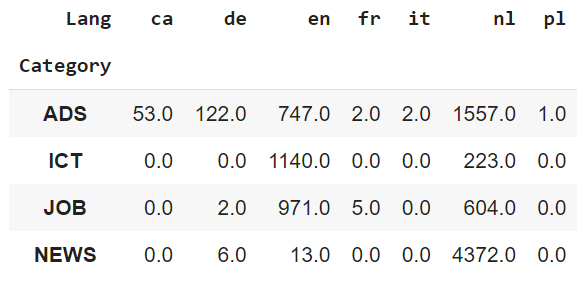

In [19]:
pd.pivot_table(data, values='Text', index=['Category'],columns=['Lang'], aggfunc='count').fillna(0)

Lang,af,ca,de,en,fr,it,nl
Category,,,,,,,
ADS,0.0,72.0,108.0,734.0,2.0,1.0,1567.0
ICT,0.0,0.0,0.0,1140.0,0.0,0.0,223.0
JOB,1.0,0.0,7.0,964.0,5.0,0.0,605.0
NEWS,0.0,0.0,9.0,9.0,0.0,0.0,4373.0


Keep only the mails in dutch or english

In [9]:
# Using the mails in dutch and english gives a better result (see Exploration 3)
data = data[(data['Lang'] == "nl") | (data['Lang'] == "en")]
data.head()


,Category,Text,Lang
0,ADS,Alles halve prijs - of nog veel goedkoper! <h...,nl
1,ADS,Alles halve prijs - of nog veel goedkoper! <h...,nl
2,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...,nl
3,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...,nl
4,ADS,"Armband met activiteitstracker, Apple iPhone 6...",nl


Remove stop words and punctuations and use a dutch stemmer (we know we should you the English stemmer for the English mails but we ignore this here).

In [20]:
# remove stopwords and punctuations
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
    
stop_words_nl = set(stopwords.words('dutch')) 

from nltk.stem.snowball import SnowballStemmer

dutchStemmer=SnowballStemmer("dutch")

punctuations="?:!.,;<>/\+-"

# define functions to remove digits stopwords from a string
# I know we are copy-pasting code, but this is for now the simpliest way

def remove_stopwords_nl(s):
    word_tokens = word_tokenize(s.lower()) # turn the string into a list of words based on separators (blank, comma, etc.)
    filtered_sentence = ""
    result = [dutchStemmer.stem(x) for x in word_tokens if x not in stop_words_nl and x not in punctuations]
    seperator = ' '
    return seperator.join(result)

data['Text'] = data['Text'].apply(remove_stopwords_nl)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcor864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcor864\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
data.head()

,Category,Text,Lang
0,ADS,halv prijs goedkoper https //www.groupon.be/an...,nl
1,ADS,halv prijs goedkoper https //www.groupon.be/an...,nl
2,ADS,krijg we wer extra korting https //www.groupon...,nl
3,ADS,krijg we wer extra korting https //www.groupon...,nl
4,ADS,armband activiteitstracker appl iphon 6/6 plus...,nl


Take a look at the data after the stopwords were removed and the stemmer was applied. A lot of those data contains pieces of what was previously an url. But because those pieces look like //www.groupon.be/analytic/trackintl.gif they won't be part of glove. This "word" will not belong to the vocabulary of word embeddings. 

Therefore replace all punctuation by a space => //www.groupon.be/analytic/trackintl.gif will become www groupon be analytic trackintl gif => groupon will be a word on it's own. Use regular expressions. You can find an example [here](https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace) (use the regex based solution!)

In [22]:
import re

def clean_pieces_urls(piece):
  return re.sub(r"[,.;@#?!&$/=]+\ *", " ", piece)

data['Text'] = data['Text'].apply(clean_pieces_urls)


In [23]:
data.head()

,Category,Text,Lang
0,ADS,halv prijs goedkoper https www groupon be ana...,nl
1,ADS,halv prijs goedkoper https www groupon be ana...,nl
2,ADS,krijg we wer extra korting https www groupon ...,nl
3,ADS,krijg we wer extra korting https www groupon ...,nl
4,ADS,armband activiteitstracker appl iphon 6 6 plus...,nl


How many mails do we have per category?

In [24]:
data.Category.value_counts()

NEWS    4391
ADS     2484
JOB     1582
ICT     1363
Name: Category, dtype: int64

Use a dictionary to replace each of the previous categories with a number 0 .. 3

In [25]:
dict_map = {'NEWS': 0, 'ADS': 1, 'JOB': 2, 'ICT': 3}
data['Category'] = data['Category'].map(dict_map)

In [26]:
data.head()

,Category,Text,Lang
0,1,halv prijs goedkoper https www groupon be ana...,nl
1,1,halv prijs goedkoper https www groupon be ana...,nl
2,1,krijg we wer extra korting https www groupon ...,nl
3,1,krijg we wer extra korting https www groupon ...,nl
4,1,armband activiteitstracker appl iphon 6 6 plus...,nl


## Using pre-trained word embeddings

What is the average length of the Text. This will be important when we need to truncate the sequences to a maximum length?  
75% of the Text's consist of how many words?

In [27]:
# Average length of the messages
data['numberOfWords'] = data.Text.str.split().apply(len)
data.head()

,Category,Text,Lang,numberOfWords
0,1,halv prijs goedkoper https www groupon be ana...,nl,2521
1,1,halv prijs goedkoper https www groupon be ana...,nl,2524
2,1,krijg we wer extra korting https www groupon ...,nl,433
3,1,krijg we wer extra korting https www groupon ...,nl,434
4,1,armband activiteitstracker appl iphon 6 6 plus...,nl,4376


In [28]:
data['numberOfWords'].describe()

count    9820.000000
mean     1556.623829
std      1242.053912
min        63.000000
25%       587.750000
50%      1306.000000
75%      2132.000000
max      7470.000000
Name: numberOfWords, dtype: float64

What is X_train, y_train, X_test, y_test?

In [29]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = data['Text']
y = data['Category']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

What is X_train, y_train, X_val, y_val?

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

What are the dimensions of X_train, X_val, X_test, y_train, y_val, y_test?

In [31]:
print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of x_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (6284,)
Shape of x_test: (1964,)
Shape of x_val: (1572,)
Shape of y_train: (6284,)
Shape of y_test: (1964,)
Shape of y_val: (1572,)


Transform X_train, X_val and X_test into an array

In [32]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)

print('X_train shape:', X_train.shape)
print(type(X_train))

X_train shape: (6284,)
<class 'numpy.ndarray'>


Convert y_train, y_val and y_test to a vector with 3 zeros and a single 1, corresponding to the right class.

In [23]:
num_classes = 4
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


### Create a vocabulary index

Use the TextVectorization to index the vocabulary found in the dataset. Later, the same layer instance will be used to vectorize the samples.

The layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually how many ? tokens long.

In [33]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=60000, output_sequence_length=2500)
text_ds = tf.data.Dataset.from_tensor_slices(X_train)  #.batch(128)
vectorizer.adapt(text_ds)


You can retrieve the computed vocabulary via vectorizer.get_vocabulary().  
Print the top 100 words

In [34]:
vectorizer.get_vocabulary()[:100]

['',
 '[UNK]',
 'be',
 'http',
 'id',
 'optiext',
 'dll',
 'optiextension',
 'https',
 'com',
 'messagent',
 'c',
 'www',
 'roulartamail',
 'email',
 'b',
 'groupon',
 's',
 'd',
 'utmsource',
 'sid',
 'nlp',
 'rm',
 'p',
 'date',
 'sender',
 'cid',
 'utmmedium',
 'body',
 'deals',
 '0',
 'tdivision',
 'ims',
 'dealpag',
 'tx',
 'images',
 'utmcampaign',
 'eh',
 'link',
 'i¿½',
 'gif',
 'uu',
 'aalst',
 'channelgod',
 '915e354cad8541b7b314080ca718db2c',
 'persgroep',
 'hln',
 '1',
 'standaard',
 'titl',
 'newsletter',
 'interactief',
 'bekijk',
 '3d',
 '51d09ac8e66a1f3df34c00064812b158bc39f676dab246be4dffa83e3f6aa31',
 't',
 'deal',
 '10x10',
 'png',
 'the',
 'les',
 'sso',
 'indeed',
 'imag',
 'click',
 '2',
 'mailing',
 'e308d190475712edb82b289ee22ec42150753ead23b9fa9f308492b8ba2e9204',
 'default',
 'ja',
 'data',
 'and',
 'from',
 'a',
 'mediafin',
 'to',
 'nl',
 'eu',
 'codeproject',
 'r',
 'linkedin',
 '00',
 'imagesgeneral',
 '2017',
 'tk',
 'vacature',
 '99',
 'vanaf',
 'rd',
 '

Vectorize a small sentence "morgen ontvangt u een nieuw bericht" 

In [35]:
output = vectorizer([["morgen ontvangt u een nieuw bericht"]])
output.numpy()[0, :20]

array([22567,   391,   181,     1,   135,   320,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int64)

What is the size of the vector coming out of vectorizer. Explain why.

In [27]:
# it's the output_sequence_length (2500). If there aren't enough words, 0 are added (this is called right padding)

By which number is the word 'morgen' represented?
Give the dict mapping words to their indices.

In [41]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
print(word_index['morgen'])

22567


Obtain the same encoding as before for the test sentence "morgen ontvangt u een nieuw bericht" using the dict. Explain why you get an error. 

In [42]:
test = ["morgen","ontvangt","u", "een", "nieuw", "bericht"]
[word_index[w] for w in test]

KeyError: 'een'

### Load pre-trained word embeddings


Make a dict mapping words (strings) to their NumPy vector representation. Download and use glove.840B.300d.txt from https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip (see https://nlp.stanford.edu/projects/glove/ for a global overview of all Glove word represenations from Stanford University). According to the documentation 840B.300d contains 2.2M words (so presumably also more dutch words) and each vector has size 300.

In [45]:
# path_to_glove_file = '/content/gdrive/My Drive/glove.6B.100d.txt'
if colab: 
  path_to_glove_file = '/content/gdrive/My Drive/glove.840B.300d.txt'
else: 
  path_to_glove_file = 'datasets/glove.840B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 2196016 word vectors.


In the previous lesson we've already used word embeddings, but for an english vocabulary. 
- How can you check if there are also dutch words in glove.840B.300d; e.g. the word 'fiets'?

In [46]:
print(embeddings_index['fiets'])

[ 0.35083    0.33208    0.38772   -0.117     -0.15331    0.39373
  0.62168    0.15369   -0.43325   -1.3817     0.091543   0.30917
 -0.10821    0.80866   -0.24606    1.1064     0.027022  -1.0071
  0.66653    0.35144    0.20424   -0.41233    0.6733     0.12141
  0.28104    0.12648   -0.042133   0.47484    0.40041    1.1454
  0.34691    0.069103   0.36171    0.38613   -0.50435    0.099638
 -0.0069929 -0.27237   -0.25542   -0.14202   -0.32847   -0.69253
  0.36678   -0.36234    0.082632  -0.56024    0.50826   -1.0186
  0.53323   -0.093632   0.21358   -0.061197   0.06286   -0.766
  0.26382   -0.26445   -0.53207    0.71299   -0.3115     0.31766
  0.70182    0.74628   -0.22612   -0.016616  -0.77156   -0.011693
 -0.6       -0.44277    0.33722   -0.99526   -0.42084   -0.72647
 -0.0889    -0.55589   -0.12587   -0.38808   -0.10379    0.1938
 -0.24074    0.60631    0.71142   -0.01253    0.15759    0.16236
 -0.66652    0.18765    1.4705     0.1796    -0.19573   -0.3624
  0.69242    0.39224    0.0948

Prepare a corresponding embedding matrix that can be ued in a Keras Embedding layer. It's a simple NumPy matrix where the entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [47]:
num_tokens = len(voc) + 2
# each word is represented by a vector of 300 floats (glove.840B.300d)
embedding_dim = 300
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# word_index is a dictionary that maps each word to an index
# we loop through all the words of word_index.items()
for word, i in word_index.items():
# we try to retrieve the vector of 100 floats for this word out of embeddings_index  
    embedding_vector = embeddings_index.get(word)
# if we found the corresponding vector of 100 floats    
    if embedding_vector is not None:
      # we put the vector on position i of embedding_matrix
        embedding_matrix[i] = embedding_vector
        hits += 1    
    else:
      # Words not found in embedding index will be all-zeros.    
        misses += 1
        missed_words.append(word)


What is the number of hits? What is the number of misses? Can you explain the sum of hits and misses?

In [48]:
print(hits)
print(misses)
        
print("Converted %d words (%d misses)" % (hits, misses))

14873
45127
Converted 14873 words (45127 misses)


Give the first 100 missed words, this means words that are not in word_index. 
- What does it mean those words are not in word_index?  
- Are you surprised those words are not in word_index?  
- Would it be better to have those words removed from Text in a previous step? Would it make a lot of difference?  


In [49]:
# Waarschijnlijk maakt het niet zo veel uit, maar we beperken wel de woorden tot 2000. 
# Dus als daar veel van zo'n woorden tussen zitten, zou het beter zijn om die te verwijderen, 
# zodat die 2000 woorden kunnen gebruikt worden voor nuttige woorden.

print("*** Missed words = words not in word_index ***")
print(missed_words[0:100])
print()

*** Missed words = words not in word_index ***
['', '[UNK]', 'optiext', 'optiextension', 'messagent', 'roulartamail', 'utmsource', 'utmmedium', 'tdivision', 'dealpag', 'utmcampaign', 'i¿½', 'channelgod', '915e354cad8541b7b314080ca718db2c', 'persgroep', '51d09ac8e66a1f3df34c00064812b158bc39f676dab246be4dffa83e3f6aa31', 'e308d190475712edb82b289ee22ec42150753ead23b9fa9f308492b8ba2e9204', 'mediafin', 'imagesgeneral', 'brugg', '5ae39b0b9008841b5410a15a', 'mpss', '2uphaa', 'aqh3dzpfrk6vsw', '3ali', '3apag', 'mlsend', 'channelgoodsdeal', 'midtoken', 'trkemail', 'groupontravel', 'westvlaander', 'oostvlaander', 'decort', 'vummail', '7egroup', 'nationaledeal', 'webbit', '7ediscussion', 'imageshln', 'slgnt', 'bricobelgium', 'channelgetawaysdeal', 'imagesupload', 'dsocdn', 'akamaized', 'r25295981474402981087600458737507', 'clicksroularta', 'adhese', 'oostkamp', 'lsred', 'jobalert', 'dataanalyst', '3aemailb2anetdigestweekly', 'mlsend2', 'uitschrijv', 'ci8020', '3de552', 'bhid', 'm1716716396', 'verz

- What is de index of the word 'fiets'.
- Give the vector by which the word will be replaced.

In [52]:
print("*** fiets has which index in word_index? ***")
index_fiets = word_index['fiets']
print(index_fiets)

*** fiets has which index in word_index? ***
5582


### Build the model

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [53]:
X_train_final = vectorizer(np.array([s for s in X_train])).numpy()
X_val_final =  vectorizer(np.array([s for s in X_val])).numpy()
X_test_final = vectorizer(np.array([s for s in X_test])).numpy()

y_train_final = np.array(y_train)
y_val_final = np.array(y_val)
y_test_final = np.array(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_val_final.shape)
print(y_test_final.shape)

(6284,)
(1572,)
(1964,)
(6284, 2500)
(1572, 2500)
(1964, 2500)
(6284,)
(1572,)
(1964,)


Create a small ANN model to predict the email category. Load the pre-trained word embeddings matrix into an Embedding layer.

Compile the model.

Train the model.

Evaluate the model

In [54]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [56]:
num_classes = 4

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    model.add(Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=2500,embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
    model.add(keras.layers.Flatten(input_shape=[num_tokens, embedding_dim]))

    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.25))
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01),
                  metrics=['accuracy']) 
    return model


In [57]:
model = initial_model()

batch_size = 350
epochs = 40

history = model.fit(X_train_final, y_train_final,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val_final, y_val_final)
                    )

Epoch 1/40
18/18 [==============================] - 28s 2s/step - loss: 31.3041 - accuracy: 0.5360 - val_loss: 0.6985 - val_accuracy: 0.8321
Epoch 2/40
18/18 [==============================] - 25s 1s/step - loss: 2.9017 - accuracy: 0.7187 - val_loss: 0.4853 - val_accuracy: 0.8263
Epoch 3/40
18/18 [==============================] - 22s 1s/step - loss: 1.5675 - accuracy: 0.7686 - val_loss: 0.4457 - val_accuracy: 0.8397
Epoch 4/40
18/18 [==============================] - 21s 1s/step - loss: 1.1404 - accuracy: 0.7969 - val_loss: 0.3639 - val_accuracy: 0.8416
Epoch 5/40
18/18 [==============================] - 21s 1s/step - loss: 1.2227 - accuracy: 0.8305 - val_loss: 0.3632 - val_accuracy: 0.8925
Epoch 6/40
18/18 [==============================] - 20s 1s/step - loss: 0.7652 - accuracy: 0.8544 - val_loss: 0.2917 - val_accuracy: 0.9090
Epoch 7/40
18/18 [==============================] - 20s 1s/step - loss: 0.4296 - accuracy: 0.8802 - val_loss: 0.2484 - val_accuracy: 0.9167
Epoch 8/40
18/18 [=

Training set Accuracy:   1.00
Training set Loss: 0.0106

Validation set Accuracy:   0.98
Validation set Loss: 0.2684



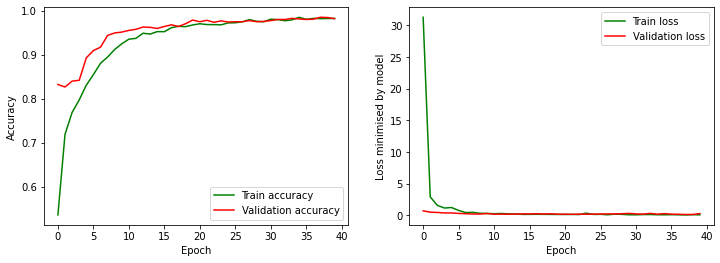

In [58]:
[train_loss, train_accuracy] = model.evaluate(X_train_final, y_train_final, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val_final, y_val_final, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history)

### Exploration

Try different values for number of epochs and batch size. Make sure the batch size is large enough!  
Add extra (dropout) layers to the ANN.

### A few thoughts ...
These results are based on the mailbox of 1 person. 
- Do you think the result will improve if you combine the mailboxes of a lot of people in order to get more trainingsdata? 
- What other reasons can you think of why the result is this good?

### Unseen email
Write a function to classify an unseen e-mail text. This function can then be integrated as an inbox rule in the e-mail program. This step is called deployment of the model and the corresponding workload might not be underestimated.

In [59]:
def predict_category(s, model=model):
    t = remove_stopwords_nl(s)
    t = clean_pieces_urls(s)
    v = vectorizer(np.array([s for s in [t]])).numpy()
    pred = model.predict([v])
    return pred


In [60]:
example = "Pauwels consulting is looking for an experienced PHP back- end developer to complete its development team . "
print(predict_category(example, model))

[[1.46415705e-05 1.96981127e-03 1.36051467e-02 9.84410405e-01]]


In [51]:
'''
dict_map = {'NEWS': 0, 'ADS': 1, 'JOB': 2, 'ICT': 3}
data['Category'] = data['Category'].map(dict_map)
'''

## Confusion matrix
Create and show the confusion matrix that shows only very few messages are "off-diagonal".

In [61]:
y_test_predictions = model.predict(X_test_final)

In [68]:
y_test_predictions

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [5.2452601e-13, 1.1199696e-09, 3.3700427e-12, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

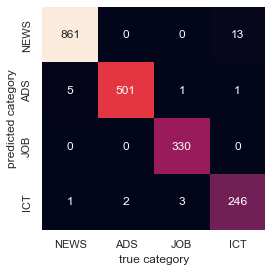

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.style.use('classic')
%matplotlib inline
import seaborn as sns; sns.set()

y_pred = np.argmax(y_test_predictions, axis=-1)

y_true=y_test_final

mat = confusion_matrix(y_true, y_pred)

labels = ['NEWS','ADS','JOB','ICT']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category');